In [3]:
import numpy as np
import scipy
import pandas as pd
from pandas import Series
from matplotlib import pyplot
import math
import random
import sklearn
from sklearn import metrics
import seaborn as sns
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import Imputer 

#april = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/infra_prediction/sap_sm37_prediction_april_staging_delayed_joined.csv')
#feb = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/infra_prediction/sap_sm37_prediction_feb_staging_delayed_joined.csv')
cpu = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/infra_prediction/sap_st06_cpu_hostname_feb_july_activestream_prod.csv')
mem = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/infra_prediction/sap_st06_mem_nov_july_activetream_prod.csv')
mem.head(10)
cpu.dtypes

_time                 object
azmspwi031_AEP_01    float64
azmspwi032_AEP_01    float64
azmspwi037_AEP_01    float64
azmspwi038_AEP_01    float64
dtype: object

### Data Analysis

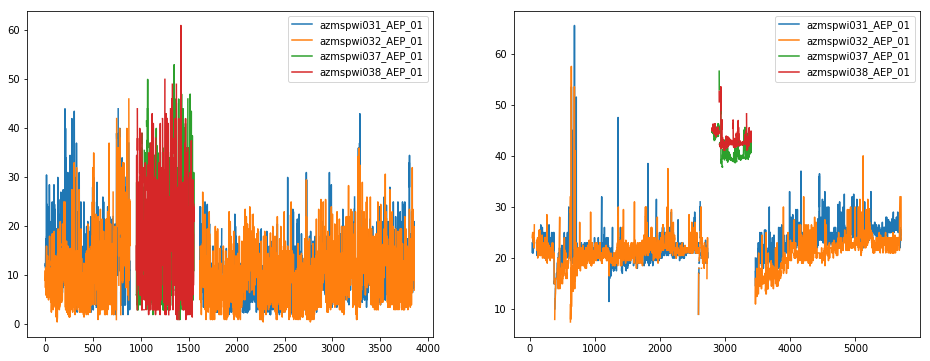

In [4]:
plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
cpu.plot(ax=ax1,kind='line')
mem.plot(ax=ax2, kind='line')
plt.show()

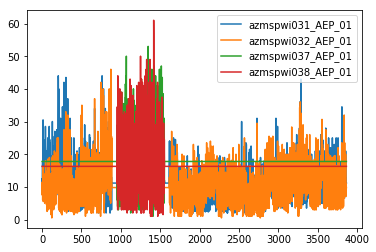

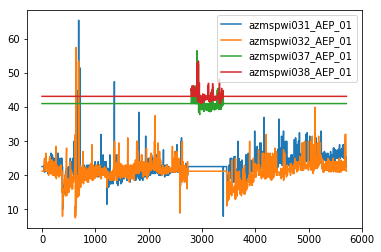

In [5]:
## Adding values based on the overall mean of the column

cpu_filled = cpu.fillna(cpu.mean())
mem_filled = mem.fillna(mem.mean())
cpu_filled.plot(kind='line')
mem_filled.plot(kind='line')

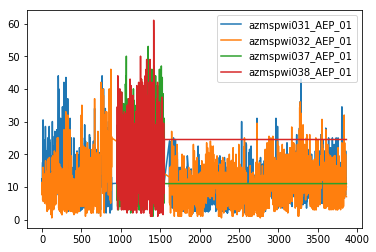

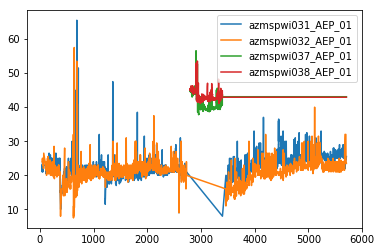

In [6]:
## Interpolating values based on linear interpolation

cpu_inter = cpu.interpolate(method='linear')
mem_inter = mem.interpolate(method='linear')
cpu_inter.plot(kind='line')
mem_inter.plot(kind='line')

<Figure size 1152x432 with 0 Axes>

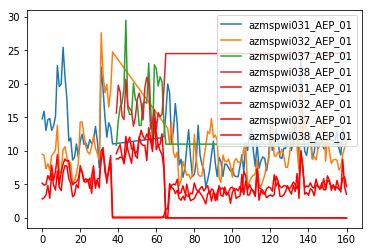

In [7]:
# Mean and variance over time 
average = cpu_inter.groupby(np.arange(len(cpu_inter))//24).mean()
std = cpu_inter.groupby(np.arange(len(cpu_inter))//24).std()
std
plt.figure(figsize=(16,6))
ax1=average.plot(kind='line')
std.plot(ax=ax1, kind='line', color='red')
plt.show()

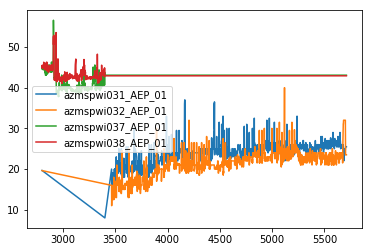

In [18]:
mem_inter.dropna(inplace=True)
mem_inter.plot()
plt.show()

In [23]:
split = int(len(cpu_inter) / 4)
#cpu_inter['avg(Value)'] = cpu_inter['azmspwi031_AEP_01']
#cpu_inter = cpu_inter.iloc[:,[0, 5]]

cpu_values = cpu_inter['avg(Value)']
#mem_values = mem_inter['avg(Value)']
cpu_means = []
#mem_means = []
cpu_variances = []
#mem_variances = []
for i,j in zip(range(4),range(1,5)):
    l = i * split 
    k = j * split 
    X1 = cpu_values[l:k]
 #   X2 = mem_values[l:k]
    cpu_mean, cpu_var = X1.mean(), X1.var()
 #   mem_mean, mem_var = X2.mean(), X2.var()
    print('cpu mean1=%f ' % (cpu_mean))
    print('cpu variance1=%f ' % (cpu_var))
    cpu_means.append(cpu_mean)
    cpu_variances.append(cpu_var)
 #   mem_means.append(mem_mean)
 #   mem_variances.append(mem_var)
    

cpu mean1=13.876893 
cpu variance1=56.463886 
cpu mean1=11.626816 
cpu variance1=11.901159 
cpu mean1=8.503106 
cpu variance1=18.933266 
cpu mean1=11.494479 
cpu variance1=28.868421 


In [24]:
cpu_values.dropna(inplace=True)
result = adfuller(cpu_values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.131922
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


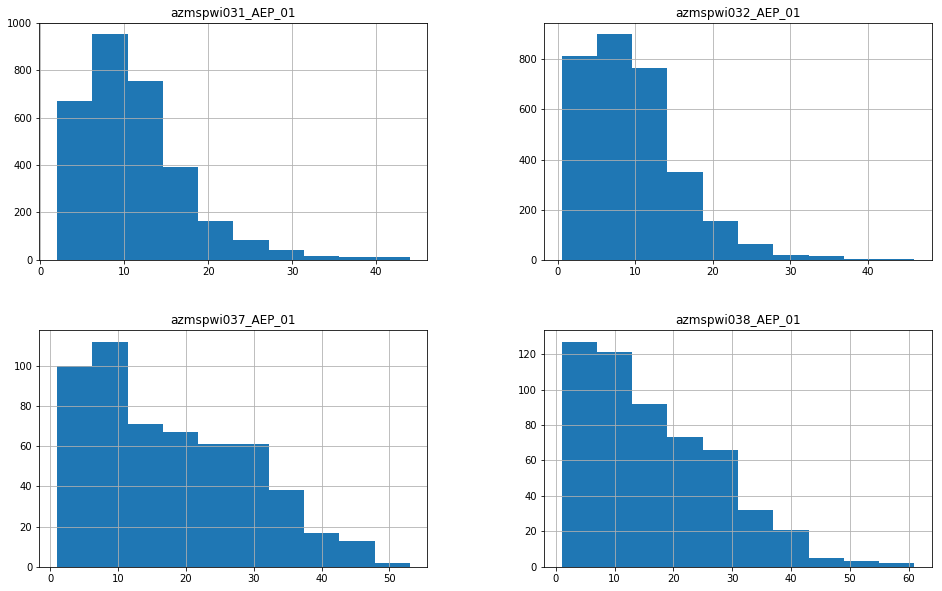

In [25]:
cpu_means = pd.Series(cpu_means)
cpu_variances = pd.Series(cpu_variances)
#mem_means = pd.Series(mem_means)
#mem_variances = pd.Series(mem_variances)
fg, axarr = plt.subplots(3,2, figsize=(16,10))
cpu.hist(ax=axarr[0,0])
#mem.hist(ax=axarr[0,1])
cpu_means.plot(kind='bar', ax=axarr[1,0], title='cpu means')
cpu_variances.plot(kind='bar', ax=axarr[1,1], title='cpu variances')
#mem_means.plot(kind='bar', ax=axarr[2,0], title='mem means')
#mem_variances.plot(kind='bar', ax=axarr[2,1], title='mem means')


plt.show()


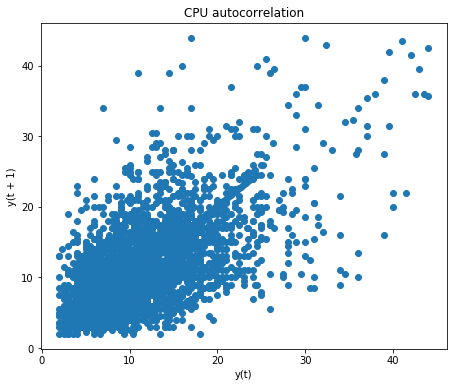

In [27]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(121)
#ax2 = plt.subplot(122)
ax=lag_plot(cpu_inter['avg(Value)'], ax=ax1)
ax.set_title('CPU autocorrelation')
#axx=lag_plot(mem['avg(Value)'], ax=ax2)
#axx.set_title('Mem autocorrelation')
plt.show()

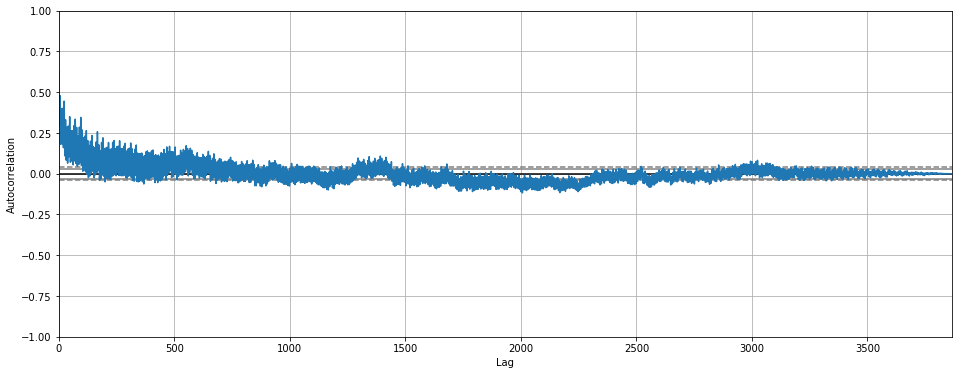

In [28]:
# CPU

plt.figure(figsize=(16,6))
autocorrelation_plot(cpu_inter['avg(Value)'])
plt.show()

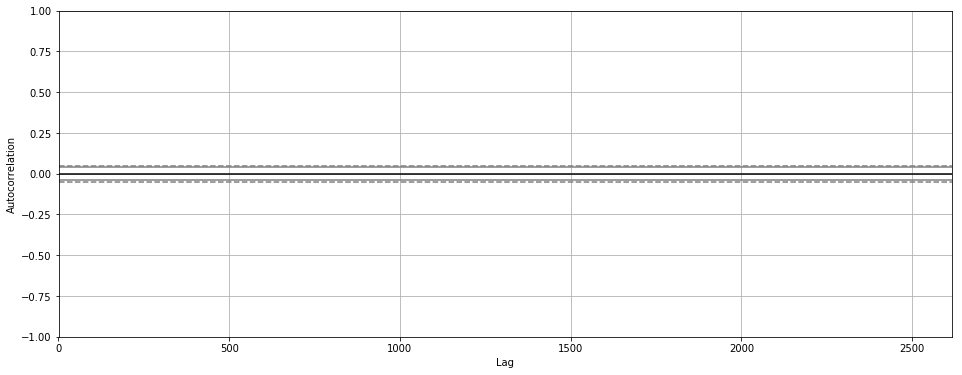

In [12]:
# Mem

plt.figure(figsize=(16,6))
small=cpu_inter.head(48)
autocorrelation_plot(mem_inter['avg(Value)'])
plt.show()

### ARIMA Model - CPU 

Model fitting

In [39]:
# split into train and test sets
X = cpu_inter['avg(Value)'].values
size = int(len(X) * 0.66)
train, test = X[:size], X[size:len(X)]

In [55]:
X.shape

(2615,)

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


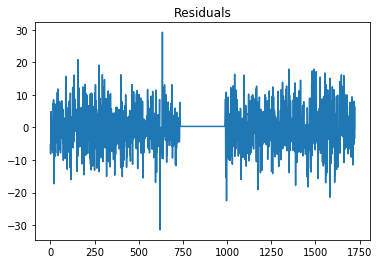

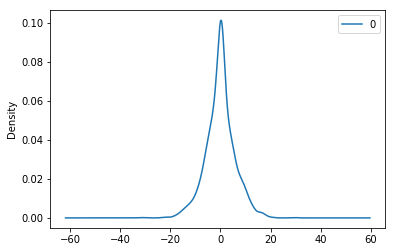

                 0
count  1724.000000
mean     -0.014202
std       5.794817
min     -31.488809
25%      -3.147771
50%       0.335450
75%       3.039379
max      29.285369


In [40]:
# train autoregression
model = ARIMA(train, order=(24,1,0))
#model_fit = model.fit()
# fit model
model_fit = model.fit(disp=0)
#print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title='Residuals', legend=False)
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


<Figure size 1152x576 with 0 Axes>

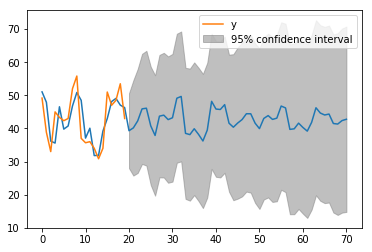

In [16]:
pred = model_fit.predict(start=len(train), end=len(train)+100)
#fig, ax = plt.subplots()
plt.figure(figsize=(16,8))
model_fit.plot_predict(start=len(train)-20, end=len(train)+50)
plt.show()

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


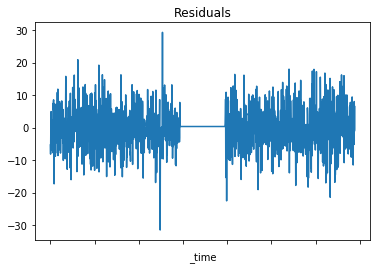

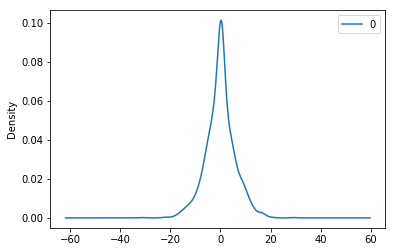

                 0
count  1723.000000
mean     -0.014215
std       5.795954
min     -31.483535
25%      -3.142041
50%       0.333544
75%       3.037455
max      29.280325


In [14]:
### Predict using date as well

train_time,test_time = cpu_inter[:size], cpu_inter[size:len(cpu_inter)]
train_time, test_time = train_time.set_index("_time"), test_time.set_index("_time")
train_time = train_time[1:]
#train_time
# train autoregression
model_time = ARIMA(train_time, order=(24,1,0))
#model_fit = model.fit()
# fit model
model_time_fit = model_time.fit(disp=0)
#print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_time_fit.resid)
residuals.plot(title='Residuals', legend=False)
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


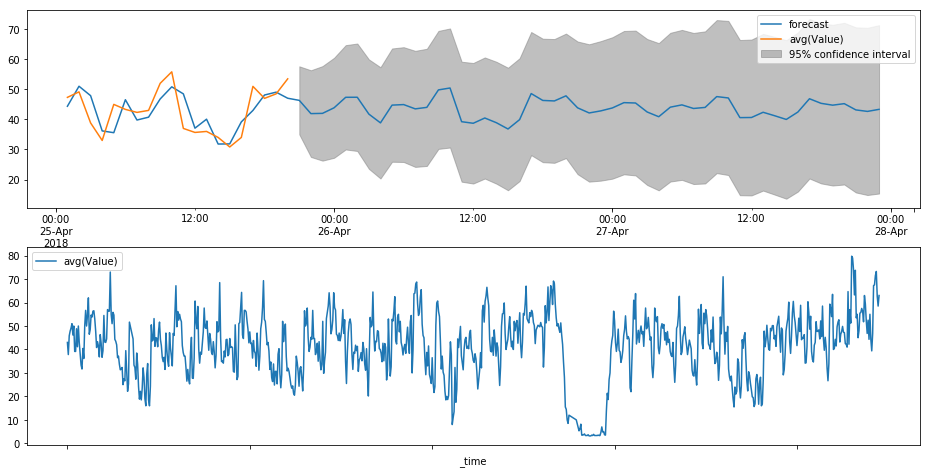

In [16]:
## Prediction
first_pred = model_time_fit.predict(start=len(train_time), end=len(train_time)+1)

plt.figure(figsize=(16,8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

model_time_fit.plot_predict(start=len(train_time)-20, end=len(train_time)+50, ax=ax1)
test_time.plot(ax=ax2, kind='line')
plt.show()



In [36]:
test['_time'].astype('datetime64[ns]')
test.dtypes

_time          object
avg(Value)    float64
dtype: object

In [50]:
print(train.shape)
print(test.shape)

(1725, 2)
(891, 2)


/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


<Figure size 1152x576 with 0 Axes>

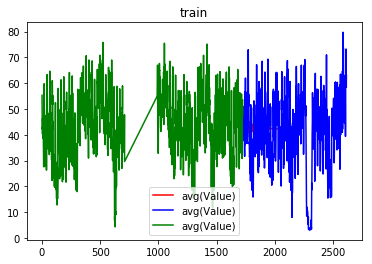

In [85]:
## Prediction

train,test = cpu_inter[:size], cpu_inter[size:len(cpu_inter)]
test['_time'].astype('datetime64[ns]')

first_pred = model_fit.predict(start=len(train), end=len(train)+500, typ='levels')
first_pred = pd.DataFrame(first_pred)
first_pred.columns = ['avg(Value)']
first_pred.index += 1725

plt.figure(figsize=(16,8))
ax1 = first_pred.plot(kind='line', color='red', title='Prediction')
test.plot(ax=ax1, kind='line', color='blue', title='test')
train.plot(ax=ax1, kind='line', color='green', title='train')
plt.show()



### Decomposition - additive 

In [86]:
#cpu.dropna(inplace=True)
#series = cpu.values
result = seasonal_decompose(X, model='additive', freq=1)
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

[55.33333333 50.         42.33333333 ... 62.75       58.5
 63.        ]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[55.33333333 50.         42.33333333 ... 62.75       58.5
 63.        ]


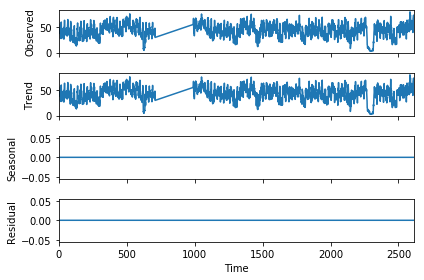

In [87]:
result.plot()
pyplot.show()

Model Prediction/Forecasting

In [113]:
train, test = cpu_inter[0:size], cpu_inter[size:len(cpu_inter)]
#train = train[1:,1]
test = np.array(test['avg(Value)'])
test

array([37.83333333, 45.83333333, 47.83333333, 49.16666667, 51.        ,
       46.16666667, 50.        , 39.16666667, 39.16666667, 48.83333333,
       41.16666667, 50.        , 42.83333333, 38.33333333, 33.33333333,
       31.66666667, 40.44444444, 36.16666667, 50.16666667, 56.66666667,
       50.        , 54.5       , 62.        , 46.5       , 48.5       ,
       54.66666667, 53.83333333, 56.33333333, 56.5       , 53.        ,
       47.83333333, 40.83333333, 43.33333333, 41.5       , 36.83333333,
       46.33333333, 42.66666667, 36.66666667, 39.5       , 54.5       ,
       43.16666667, 43.        , 44.5       , 57.        , 56.33333333,
       56.33333333, 73.        , 55.        , 51.        , 55.83333333,
       54.66666667, 44.33333333, 43.5       , 42.        , 36.5       ,
       37.16666667, 33.66666667, 31.33333333, 31.66666667, 32.33333333,
       25.        , 27.5       , 26.66666667, 39.5       , 31.        ,
       22.16666667, 25.33333333, 51.66666667, 49.875     , 48.08

In [114]:
# split into 2/3 of data
size = int(len(cpu_inter) * 0.66)
train, test = cpu_inter[0:size], cpu_inter[size:len(cpu_inter)]
#train = train[1:,1]
history = [x for x in train['avg(Value)']]
test = np.array(test['avg(Value)'])
history = history[1:]
history
predictions = []
for i in range(len(train)):
    model = ARIMA(history, order=(24,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    #print(output)
    yhat = output[0]
    predictions.append(yhat)
    #t = 168 + i
    obs = test[i]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

#test2 = test[len(test):len(test)+10]
    
error = metrics.mean_squared_error(test, predictions)
#print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


predicted=39.303619, expected=37.833333
predicted=39.008126, expected=45.833333


KeyboardInterrupt: 

### AR Model - CPU

In [26]:
print("training shape:  " + str(train_time.shape))
#print("training dtype:  " + train_time.dtypes)
print("test shape:  " + str(test_time.shape))
# print("training dtype:  " + str(test_time.dtypes))


training shape:  (1724, 1)
test shape:  (891, 1)


In [27]:
# split into train and test sets
size = int(len(cpu_inter) * 0.66)
train_orig, test_orig = cpu_inter[:size], cpu_inter[size:len(cpu_inter)]
test_ar = np.array(test_orig)

Lag: 24
Coefficients: [ 2.33415600e+00  7.28016190e-01 -1.22258999e-01  1.16853721e-01
  1.52507675e-02 -7.87400816e-03 -2.29595711e-02  7.68538015e-02
  8.05809927e-03 -4.12262853e-02  2.34425890e-02  1.36021313e-02
 -4.66334480e-02  7.40673656e-02 -3.80725412e-02 -3.20522590e-02
  2.78711068e-02  4.56645541e-02 -8.19042466e-02 -1.03363980e-02
  1.33011639e-02  2.12672500e-03 -5.11918887e-02  1.29071973e-01
  1.26813873e-01]
Test MSE: 197.547


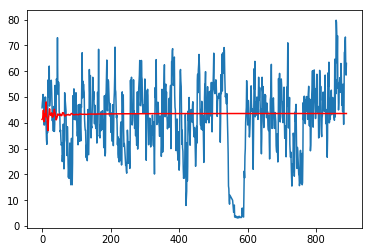

In [96]:
# train autoregression
test_ar = np.array(test_orig['avg(Value)'])
train = np.array(train_orig['avg(Value)'])
train = train[1:]
test_ar = test_ar[1:]
model_ar = AR(train)
model_ar_fit = model_ar.fit()
print('Lag: %s' % model_ar_fit.k_ar)
print('Coefficients: %s' % model_ar_fit.params)

# make predictions
predictions = model_ar_fit.predict(start=len(train), end=len(train)+len(test_ar)-1, dynamic=False)
#for i in range(len(predictions)):
#    print('predicted=%f, expected=%f' % (predictions[i], test_ar[i]))
error = metrics.mean_squared_error(test_ar, predictions)
print('Test MSE: %.3f' % error)
# plot results
#test_time['_time'].astype('datetime64[ns]')
pyplot.plot(test_ar)
pyplot.plot(predictions, color='red')
pyplot.show()



### Rolling model

Test MSE: 53.102


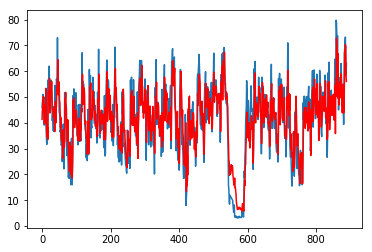

In [43]:
# train autoregression
model = AR(train)
model_fit = model.fit()
# number of coefficients i.e lag that is automatically determined
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
# the last 24 data points from train
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test_ar)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test_ar[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = metrics.mean_squared_error(test_ar, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test_ar)
#pyplot.plot(predictions, color='red')
pyplot.show()

### ARIMA Model - Mem

Joined Data Set

In [115]:
# split into train and test sets
#mem_inter.dropna(inplace=True)
#X = mem_inter['avg(Value)'].values
size_mem = int(len(mem_inter) * 0.66)
train_mem, test_mem = mem_inter[0:size], mem_inter[size:len(mem_inter)]

In [118]:
train_mem.head(1)

,_time,avg(Value)
0,2018-02-13T00:00:00.000+0000,NaN


In [119]:
# train autoregression
train_mem[1:]
model_mem = ARIMA(train_mem, order=(24,1,0))

# fit model
model_mem_fit = model_mem.fit(disp=0)
#print(model_mem_fit.summary())
# plot residual errors
residuals_mem = pd.DataFrame(model_mem_fit.resid)
residuals_mem.plot()
pyplot.show()
residuals_mem.plot(kind='kde')
pyplot.show()
print(residuals_mem.describe())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

Prediction

In [ ]:
## Prediction
first_pred = model_mem_fit.predict(start=len(train_time), end=len(train_time)+1)

plt.figure(figsize=(16,8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

model_time_fit.plot_predict(start=len(train_time)-20, end=len(train_time)+50, ax=ax1)
test_time.plot(ax=ax2, kind='line')
plt.show()

In [ ]:
# split into 2/3 of data
size = int(len(small_mem) * 0.66)
train, test = small[0:size], small[size:len(small)]
history = [x for x in train]
predictions = []
for i in range(len(train)):
    model = ARIMA(history, order=(24,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    #print(output)
    yhat = output[0]
    predictions.append(yhat)
    t = 168 + i
    obs = test[t]
    #history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

test2 = test[len(test):len(test)+10]
    
error = metrics.mean_squared_error(test2, predictions)
#print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test2)
pyplot.plot(predictions, color='red')
pyplot.show()